In [102]:
import bs4 as bs
import datetime as dt
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import os
import pickle
import requests
from IPython.display import clear_output

A function to scrape all first north company tickers from www.nasdaqomxnordic.com.

In [60]:
def save_first_north_tickers():
    resp = requests.get('http://www.nasdaqomxnordic.com/shares/listed-companies/first-north')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('article', {'class':'nordic-our-listed-companies'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        ticker = ticker.replace(' ', '-')
        ticker = ticker+'.ST'
        
        tickers.append(ticker)
        
    with open('first-north-all-tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    return tickers

A function that downloads the history data from yhaoo using the scraped tickers.

In [3]:
def get_data_from_yahoo(reload_data=False):
    if reload_data:
        tickers = save_first_north_tickers()
    else:
        with open('first-north-all-tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('first-north-dfs'):
        os.makedirs('first-north-dfs')
        
    for ticker in tickers:
        print(ticker)
        try:
            df = web.DataReader(ticker, 'yahoo')
            file_name = 'first-north-dfs/{}.csv'.format(ticker)
            if not os.path.exists(file_name):
                df.to_csv(file_name)
            else:
                print('Already have {}'.format(ticker))
        except:
            print('{} does not exist'.format(ticker))

In [4]:
#get_data_from_yahoo()

In [61]:
def clean_tickers():
    with open('first-north-all-tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    new_tickers = []
    for ticker in tickers:
        try:
            df = pd.read_csv('first-north-dfs/{}.csv'.format(ticker), index_col=0, parse_dates=True)
            new_tickers.append(ticker)
        except:
            print('{} is not on yahoo'.format(ticker))
            
    with open('first-north-tickers.pickle', 'wb') as f:
        pickle.dump(new_tickers, f)    

In [62]:
clean_tickers()

ADDV-TO-1.ST is not on yahoo
ANOT-TO-18.ST is not on yahoo
BRIG-BTA.ST is not on yahoo
BRIG-TO3.ST is not on yahoo
BRIG-TO4.ST is not on yahoo
CHRO-TO2.ST is not on yahoo
CI-TO-1-B.ST is not on yahoo
HDW-TO-2-B.ST is not on yahoo
MAHA-TO-2-A.ST is not on yahoo
QUART-BTA-PR.ST is not on yahoo
SALT-TO6-B.ST is not on yahoo
SECI-TO-1.ST is not on yahoo
AGILC.ST is not on yahoo
CBM.ST is not on yahoo
CONFRZ.ST is not on yahoo
DAC.ST is not on yahoo
EGNETY.ST is not on yahoo
ENALYZ.ST is not on yahoo
ERRIA.ST is not on yahoo
ESOFT.ST is not on yahoo
FASTPC.ST is not on yahoo
GATE.ST is not on yahoo
GREENM.ST is not on yahoo
HAPPY.ST is not on yahoo
HRC.ST is not on yahoo
HYPE.ST is not on yahoo
JOBNDX.ST is not on yahoo
KONSOL.ST is not on yahoo
NPINV.ST is not on yahoo
ODICO.ST is not on yahoo
SCAPE.ST is not on yahoo
SLXIT.ST is not on yahoo
VIRO.ST is not on yahoo
WATURU.ST is not on yahoo
WIRTEK.ST is not on yahoo
HAMP.ST is not on yahoo
KALD.ST is not on yahoo
KLAPP-B.ST is not on yaho

Visualizing the data for the company Iconovo.

In [5]:
import matplotlib.pyplot as plt
import mplfinance as mpf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

In [6]:
ico = pd.read_csv('first-north-dfs/ICO.ST.csv', index_col=0, parse_dates=True)
ico.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-04-06,43.000000,34.500000,38.400002,36.000000,33693,36.000000
2018-04-09,37.000000,33.200001,37.000000,34.799999,14726,34.799999
2018-04-10,34.799999,29.500000,34.799999,34.500000,67172,34.500000
2018-04-11,34.500000,29.600000,34.500000,33.200001,57515,33.200001
2018-04-12,33.400002,30.000000,32.000000,33.400002,6514,33.400002


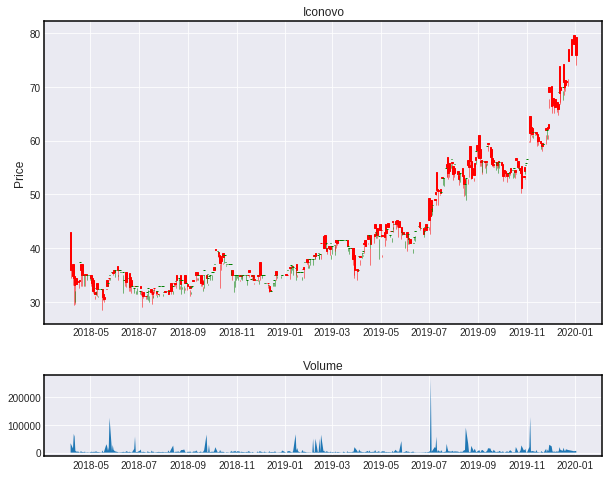

In [12]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=7, colspan=1)
ax1.xaxis_date()
ax2 = plt.subplot2grid((10,1), (8,0), rowspan=2, colspan=1, sharex=ax1)

ico_ohlc = ico.drop(['Volume', 'Adj Close'], axis=1)
ico_ohlc.reset_index(inplace=True)
ico_ohlc['Date'] = ico_ohlc['Date'].map(mdates.date2num)

ico_volume = ico[['Volume']]

candlestick_ohlc(ax1, ico_ohlc.values, width=2, colorup='g')
ax1.set_title('Iconovo')
ax1.set_ylabel('Price')
ax2.fill_between(ico_volume.index.map(mdates.date2num), ico_volume.values.flatten())
ax2.set_title('Volume');

In [84]:
def complile_data():
    
    with open('first-north-tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for i, ticker in enumerate(tickers):
        df = pd.read_csv('first-north-dfs/{}.csv'.format(ticker), index_col=0, parse_dates=True)
        df.rename(columns={'Adj Close':ticker}, inplace=True)
        
        if main_df.empty:
            main_df = df[[ticker]]
        else:
            main_df = main_df.join(df[[ticker]], how='outer')
        
        if not i % 10:
            clear_output(wait=True)
            print(i)
            
    main_df.to_csv('first-north-joined.csv')

In [85]:
complile_data()

330


In [127]:
def visualize_data():
    df = pd.read_csv('first-north-joined.csv')
    df_corr = df.corr()
    
    data = df_corr.values
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdBu)
    heatmap.set_clim(-1,1)
    fig.colorbar(heatmap)
    
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    colum_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(colum_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)

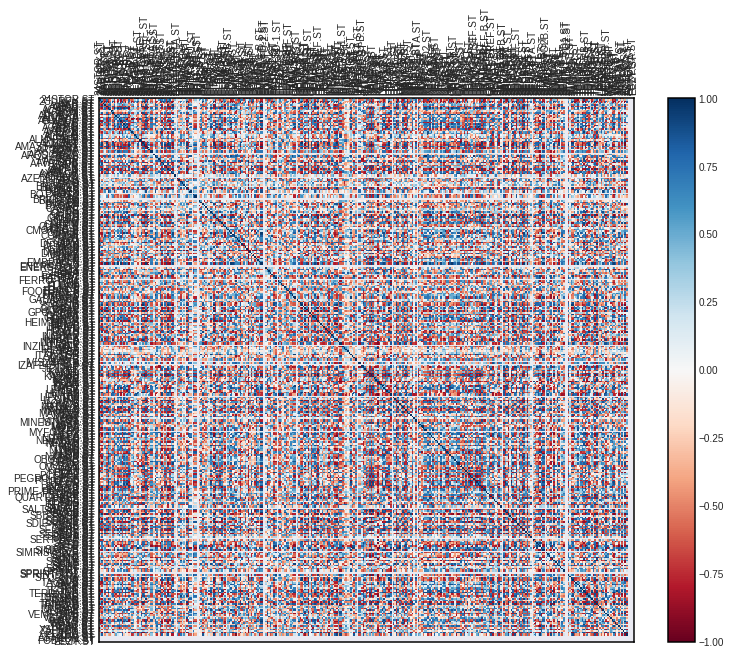

In [128]:
visualize_data()